In [24]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

%matplotlib inline

In [25]:
rdf = pd.read_csv('rdf_ysi_large_190501.csv.gz', index_col=0)
rdf = rdf.drop_duplicates(subset=['molecule', 'fragment1', 'fragment2'])
rdf.head()

,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo
rid,,,,,,,
845604,O=CNCCc1ccccc1,1,[CH]=O,[NH]CCc1ccccc1,100.838814,C-N,0
845606,O=CNCCc1ccccc1,3,[CH2]NC=O,[CH2]c1ccccc1,73.204572,C-C,0
845607,O=CNCCc1ccccc1,4,[CH2]CNC=O,[c]1ccccc1,103.215818,C-C,0
845608,O=CNCCc1ccccc1,11,[H],O=[C]NCCc1ccccc1,93.268545,C-H,0
845609,O=CNCCc1ccccc1,12,[H],O=C[N]CCc1ccccc1,109.856746,H-N,0


In [26]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)

In [27]:
import pickle
import gzip

with gzip.open('processed_inputs_190531.p.gz', 'rb') as f:
    preprocessor_data = pickle.load(f)
    
preprocessor = preprocessor_data['preprocessor']
inputs = preprocessor.predict(rdf.molecule.unique())

100%|██████████| 91/91 [00:00<00:00, 953.60it/s]


In [28]:
from keras.models import load_model
from nfp import custom_layers
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    model = load_model('layer_runs2/n_message_6/best_model.hdf5', custom_objects=custom_layers)
    
from preprocessor_utils import ConcatGraphSequence
new_pred = model.predict_generator(
    ConcatGraphSequence(inputs, batch_size=128, shuffle=False), verbose=1)

1/1 [==============================] - 1s 1s/step


In [29]:
def get_df(iinput, smiles, i):
    idf = pd.DataFrame(iinput['bond_indices'], columns=['bond_index'])
    idf['preprocessor_class'] = iinput['bond']
    idf['molecule'] = smiles
    idf['mol_index'] = i
    return idf

y_new_df = pd.concat([
    get_df(iinput, smiles, i) for i, (iinput, smiles)
    in enumerate(zip(inputs, rdf.molecule.unique()))])

y_new_df['bde_pred'] = new_pred
y_new_df = y_new_df.groupby(['molecule', 'bond_index']).mean().reset_index()
y_new_df.head()

,molecule,bond_index,preprocessor_class,mol_index,bde_pred
0,C(=C\c1ccccc1)\c1ccccc1,0,23.0,57.0,93.364204
1,C(=C\c1ccccc1)\c1ccccc1,1,2.0,57.0,114.291946
2,C(=C\c1ccccc1)\c1ccccc1,2,11.0,57.0,84.785675
3,C(=C\c1ccccc1)\c1ccccc1,3,11.0,57.0,93.262398
4,C(=C\c1ccccc1)\c1ccccc1,4,11.0,57.0,93.091125


In [30]:
db_with_pred = rdf.merge(
    y_new_df[['molecule', 'bond_index', 'bde_pred']],
    on=['molecule', 'bond_index'], how='left')

db_with_pred.head()

,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred
0,O=CNCCc1ccccc1,1,[CH]=O,[NH]CCc1ccccc1,100.838814,C-N,0,100.994446
1,O=CNCCc1ccccc1,3,[CH2]NC=O,[CH2]c1ccccc1,73.204572,C-C,0,72.824829
2,O=CNCCc1ccccc1,4,[CH2]CNC=O,[c]1ccccc1,103.215818,C-C,0,102.839119
3,O=CNCCc1ccccc1,11,[H],O=[C]NCCc1ccccc1,93.268545,C-H,0,94.756805
4,O=CNCCc1ccccc1,12,[H],O=C[N]CCc1ccccc1,109.856746,H-N,0,110.333862


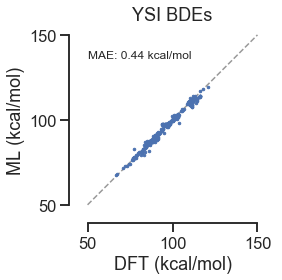

In [31]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal')
plt.plot(db_with_pred.bde, db_with_pred.bde_pred, '.', ms=5)
plt.plot([50, 150], [50, 150], '--', zorder=0, color='.6', lw=1.5)

ax.text(.05, .875,
        'MAE: {:0.2f} kcal/mol'.format((db_with_pred.bde - db_with_pred.bde_pred).abs().mean()),
        transform=ax.transAxes, ha='left', va='top', fontsize='large')

ax.set_yticks([50, 100, 150])

sns.despine(offset=10, trim=True)

ax.set_ylabel('ML (kcal/mol)')
ax.set_xlabel('DFT (kcal/mol)')
ax.set_title('YSI BDEs')

plt.tight_layout()

plt.savefig('ysi_bde_prediction.svg')

In [32]:
from rdkit.Chem import MolFromSmiles

In [33]:
db_with_pred.molecule.apply(lambda x: MolFromSmiles(x).GetNumAtoms()).min()

11

In [34]:
db_with_pred.drop_duplicates(['molecule', 'fragment1', 'fragment2']).dropna().shape

(845, 8)

In [35]:
len(db_with_pred.molecule.unique())

91

In [36]:
db_with_pred.reindex((db_with_pred.bde - db_with_pred.bde_pred
                     ).abs().sort_values(ascending=False).index).head(10)

,molecule,bond_index,fragment1,fragment2,bde,bond_type,delta_stereo,bde_pred
724,CC1=CC2C3CC(C=C3C)C2C1,20,[H],CC1=CC2C3[CH]C(C=C3C)C2C1,103.636876,C-H,0,97.933151
191,c1ccc(C(c2ccccc2)c2ccccc2)cc1,24,[H],c1ccc([C](c2ccccc2)c2ccccc2)cc1,77.573290,C-H,0,83.059479
150,c1cc2c3c(c1)ccc1cccc(c13)C2,26,[H],[CH]1c2cccc3ccc4cccc1c4c23,83.444264,C-H,0,79.073517
44,CC(=O)n1ccc2ccccc21,2,C[C]=O,C1=Cc2ccccc2[N]1,85.890294,C-N,0,81.552818
213,c1ccc2c(c1)Cc1ccccc1-2,17,[H],[c]1cccc2c1-c1ccccc1C2,111.318214,C-H,0,107.341370
207,Cc1cccc2c1Cc1ccccc1-2,27,[H],Cc1cccc2c1Cc1ccc[c]c1-2,111.322607,C-H,0,107.601135
178,c1ccc(-c2cccc3ccccc23)cc1,3,[c]1ccccc1,[c]1cccc2ccccc12,114.613264,C-C,0,110.903702
140,c1ccc(-c2ccccc2-c2ccccc2)cc1,3,[c]1ccccc1-c1ccccc1,[c]1ccccc1,113.569716,C-C,0,110.178230
587,CCCCCCCCCCCc1ccccc1,34,[H],CCCCCCCC[CH]CCc1ccccc1,93.958805,C-H,0,97.312622
566,CCCCCCCCCCCCc1ccccc1,37,[H],CCCCCCCCC[CH]CCc1ccccc1,93.995828,C-H,0,97.312622


## Predict YSI with radicals and BDEs

In [37]:
ysi = pd.read_csv('all_ysi.csv', index_col=0)

ysi = ysi[~(
    ysi.SMILES.str.contains('Cl') | 
    ysi.SMILES.str.contains('Br') | 
    ysi.SMILES.str.contains('F') | 
    ysi.SMILES.str.contains('\+'))]

inputs_ysi = preprocessor.predict(ysi.SMILES)
ysi_bde_pred = model.predict_generator(
    ConcatGraphSequence(inputs_ysi, batch_size=128, shuffle=False), verbose=1)

100%|██████████| 561/561 [00:00<00:00, 1433.28it/s]


5/5 [==============================] - 1s 257ms/step


In [38]:
def inputs_to_dataframe(smiles, inputs):
    molecule = np.repeat(np.array(smiles), np.stack([iinput['n_bond'] for iinput in inputs]))
    bond_index = np.concatenate([iinput['bond_indices'] for iinput in inputs])
    input_df = pd.DataFrame(np.vstack([molecule, bond_index]).T, columns=['molecule', 'bond_index'])
    input_df['bond_index'] = input_df.bond_index.astype('int64')
    
    return input_df

ysi_bdes = inputs_to_dataframe(ysi.SMILES, inputs_ysi)

ysi_bdes['bde_pred'] = ysi_bde_pred
ysi_bdes = ysi_bdes.groupby(['molecule', 'bond_index']).mean().reset_index()

In [39]:
from bde.fragment import fragment_iterator

def ysi_frag_iterator():
    for smiles in tqdm_notebook(ysi.SMILES):
        for row in fragment_iterator(smiles):
            yield row

ysi_rdf = pd.DataFrame(ysi_frag_iterator())

In [40]:
ysi_rdf_merged = ysi_rdf.merge(
    ysi_bdes.groupby(['molecule', 'bond_index']).mean().reset_index(),
    on=['molecule', 'bond_index'])

smallest_bde = ysi_rdf_merged.groupby('molecule').apply(lambda df: df.loc[df.bde_pred.idxmin()])
smallest_bde = smallest_bde.merge(ysi, left_index=True, right_on='SMILES')

df = smallest_bde.melt(value_vars=['fragment1', 'fragment2'], id_vars=['molecule'], value_name='SMILES')
df['val'] = 1.
X = df.pivot_table(index='molecule', columns='SMILES', values='val')
X = X.fillna(0).astype(int)

X_subset = X.loc[:, X.sum(0) > 3]
X_subset = X_subset[X_subset.sum(1) == 2]

X_subset.shape

# from rdkit import Chem
# def get_natoms(smiles):
#     return Chem.MolFromSmiles(smiles).GetNumAtoms()

# frag1_size = smallest_bde.fragment1.apply(get_natoms)
# frag2_size = smallest_bde.fragment2.apply(get_natoms)

# smallest_bde['larg_frag'] = smallest_bde.fragment1
# smallest_bde.loc[frag2_size >= frag1_size, 'larg_frag'] = smallest_bde[frag2_size >= frag1_size].fragment2

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import mean_squared_log_error

model = LinearRegression(fit_intercept=False)

x = X_subset.values
y = ysi.set_index('SMILES').reindex(X_subset.index).YSI.values
y_err = np.abs(y) * 0.05

y_cv = cross_val_predict(model, x, y, cv=LeaveOneOut(), fit_params={'sample_weight': 1/y_err}, n_jobs=-1)

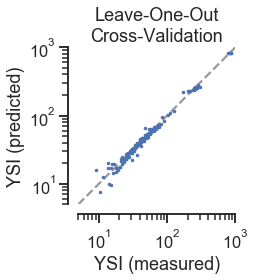

In [41]:
fig = plt.figure()

ax = fig.add_subplot(111, aspect='equal')
ax.set_yscale('log')
ax.set_xscale('log')

ax.plot(y, y_cv, '.', ms=5)
ax.plot([5, 1E3], [5, 1E3], '--', color='.6', zorder=0)

ax.set_xlim([5, 1E3])
ax.set_ylim([5, 1E3])
sns.despine(offset=10)

ax.set_xlabel('YSI (measured)')
ax.set_ylabel('YSI (predicted)')
ax.set_title('Leave-One-Out\nCross-Validation')

plt.tight_layout()

plt.savefig('ysi_loo.svg')

In [42]:
smallest_bde[((smallest_bde.fragment2 == '[CH2]C(C)=O') | (smallest_bde.fragment1 == '[CH2]C(C)=O'))             
             & smallest_bde.molecule.isin(X_subset.index)]

,molecule,bond_index,bond_type,fragment1,fragment2,delta_assigned_stereo,delta_unassigned_stereo,bde_pred,SMILES,YSI,CAS,Species
345,CC(=O)CC(C)(C)C,3,C-C,C[C](C)C,[CH2]C(C)=O,0,0,79.026169,CC(=O)CC(C)(C)C,42.7,590-50-1,"4,4-dimethyl-2-pentanone"
419,CC(=O)CC(C)C,3,C-C,C[CH]C,[CH2]C(C)=O,0,0,81.250183,CC(=O)CC(C)C,32.8,108-10-1,4-methyl-2-pentanone
487,CCCC(C)=O,1,C-C,[CH2]C(C)=O,[CH2]C,0,0,82.652000,CCCC(C)=O,21.1,107-87-9,2-pentanone
464,CCCCC(C)=O,2,C-C,[CH2]C(C)=O,[CH2]CC,0,0,82.910721,CCCCC(C)=O,25.6,591-78-6,2-hexanone
432,CCCCCC(C)=O,3,C-C,[CH2]C(C)=O,[CH2]CCC,0,0,82.871765,CCCCCC(C)=O,30.4,110-43-0,2-heptanone
384,CCCCCCC(C)=O,4,C-C,[CH2]C(C)=O,[CH2]CCCC,0,0,82.964432,CCCCCCC(C)=O,37.9,111-13-7,2-octanone
328,CCCCCCCC(C)=O,5,C-C,[CH2]C(C)=O,[CH2]CCCCC,0,0,83.008301,CCCCCCCC(C)=O,45.1,821-55-6,2-nonanone
301,CCCCCCCCC(C)=O,6,C-C,[CH2]C(C)=O,[CH2]CCCCCC,0,0,82.986641,CCCCCCCCC(C)=O,51.9,693-54-9,2-decanone


In [43]:
model.fit(x, y, sample_weight=1/y_err)
frag_df = pd.DataFrame(pd.Series(model.coef_, index=X_subset.columns,
                                 name='YSI').sort_values(ascending=False)).reset_index()

In [44]:
frag_df.head()

,SMILES,YSI
0,[CH2]c1ccc(-c2ccccc2)cc1,812.411062
1,[CH2]c1ccccc1,221.951931
2,[c]1ccccc1,107.119154
3,[NH]c1ccccc1,97.850313
4,[CH2]C#CC,55.636803
